## **Import libraries and packages**

In [2]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications import inception_v3
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import seaborn
import seaborn as sns

# import time
from time import time

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## **Load the dataset**

In [7]:
train_dir = '../data/training_data/'
val_dir = '../data/validation_data/'
test_dir = '../data/testing_data/'

## **Data Augmentation**

In [8]:
training_batch_size = 16
validation_batch_size = 16
def get_images(img_size, preprocessing):

  
  train_datagen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip= True,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode="nearest",
                              preprocessing_function = preprocessing)
  
  datagen = ImageDataGenerator(preprocessing_function= preprocessing)
  
  train_datagen = train_datagen.flow_from_directory(train_dir,
                                            batch_size= training_batch_size,
                                            shuffle= True,
                                            target_size = (img_size, img_size),
                                            classes = ['Disturbed', 'Undisturbed'])
  
  val_datagen = datagen.flow_from_directory(val_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Disturbed', 'Undisturbed'])
  
  test_datagen = datagen.flow_from_directory(test_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Disturbed', 'Undisturbed'])
  
  return train_datagen, val_datagen, test_datagen

In [9]:
train_datagen, val_datagen, test_datagen = get_images(299, preprocessing= inception_v3.preprocess_input)

Found 220 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [40]:
def visualize_training(history, epochs):
    fig = plt.figure(figsize=(16,12))
     #plt.subplot(1,2,1)
    plt.plot(history.history['accuracy']);
    plt.plot(history.history['val_accuracy'])
    plt.title("Model Accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.figsize()
    label_1 = "{:.2f}".format(history.history['accuracy'][-1])
    label_2 = "{:.2f}".format(history.history['val_accuracy'][-1])
    plt.annotate(label_1, (epochs-1,history.history['accuracy'][-1]), textcoords="offset points", 
                 xytext=(0,10),ha='center')
    plt.annotate(label_2, (epochs-1,history.history['val_accuracy'][-1]), textcoords="offset points", 
                 xytext=(0,10),ha='center')
    plt.legend(['training', 'validation'], loc='upper left')
    fig = plt.figure(figsize=(16,12))
    #plt.subplot(1,2,2)
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    label_3 = "{:.2f}".format(history.history['loss'][-1])
    label_4 = "{:.2f}".format(history.history['val_loss'][-1])
    plt.annotate(label_3, (epochs-1,history.history['loss'][-1]), textcoords="offset points", 
                 xytext=(0,10),ha='center')
    plt.annotate(label_4, (epochs-1,history.history['val_loss'][-1]), textcoords="offset points", 
                 xytext=(0,10),ha='center')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

In [13]:
def print_classification_report(model, data_gen, batch_size):
    true_labels = data_gen.labels
    data_gen.reset()
    predicted_labels = model.predict(data_gen, steps = np.ceil(len(true_labels)/batch_size))
    #print(list( np.argmax(a) for a in predicted_labels), true_labels)
    print(classification_report(true_labels, list( np.argmax(a) for a in predicted_labels)))
    print("Confusion Matrix:\n ",confusion_matrix(true_labels,list( np.argmax(a) for a in predicted_labels)))

## **Build the model**

In [14]:
inception_base = inception_v3.InceptionV3(weights='imagenet', include_top= False, input_shape= (299, 299, 3))

87916544/87910968 [==============================] - 15s 0us/step


In [15]:
inception_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
model = models.Sequential()
model.add(inception_base)
model.add(keras.layers.GlobalAveragePooling2D())
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(512, activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [17]:
inception_base.trainable = False
inception_base.training = False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Compile the model**

In [19]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, 
                                             momentum=0.9, 
                                             nesterov= False), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = '../models/inception-model.h5',
        monitor = 'val_accuracy',
        verbose=1,
        save_best_only = True),
        keras.callbacks.EarlyStopping(
            monitor= 'val_accuracy',
            patience = 6,
            mode = 'max',
            verbose= 1
        )]

## **Train the model**

In [32]:
n_epochs = 4
history = model.fit(train_datagen,
                    steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                    epochs=n_epochs,
                    validation_data=val_datagen,
                    validation_steps = int(np.ceil(len(val_datagen.filenames)/validation_batch_size)))

Epoch 1/4
13/13 [==============================] - 4s 280ms/step - loss: 0.5713 - accuracy: 0.7108 - val_loss: 0.4853 - val_accuracy: 0.8382
Epoch 2/4
13/13 [==============================] - 4s 271ms/step - loss: 0.5403 - accuracy: 0.7010 - val_loss: 0.4455 - val_accuracy: 0.8382
Epoch 3/4
13/13 [==============================] - 4s 275ms/step - loss: 0.4955 - accuracy: 0.8039 - val_loss: 0.4062 - val_accuracy: 0.8529
Epoch 4/4
13/13 [==============================] - 4s 269ms/step - loss: 0.4612 - accuracy: 0.7941 - val_loss: 0.3811 - val_accuracy: 0.8676


## **Fine tune the model**

In [33]:
inception_base.trainable = True
set_trainable = False
for layer in inception_base.layers[:249]:
    set_trainable = False
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable= False

In [34]:
for layer in inception_base.layers[249:]:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [35]:
for i, layer in enumerate(inception_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [36]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, 
                                             momentum=0.9, 
                                             nesterov = False), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [38]:
n_epochs = 40
history = model.fit(train_datagen,
                    steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                    epochs=n_epochs,
                    validation_data=val_datagen,
                    validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                    callbacks=callbacks_list,
                    verbose= 1)

Epoch 1/40
13/13 [==============================] - 7s 341ms/step - loss: 0.4778 - accuracy: 0.7971 - val_loss: 0.3666 - val_accuracy: 0.8529

Epoch 00001: val_accuracy improved from -inf to 0.85294, saving model to ../models/inception-model.h5
Epoch 2/40
13/13 [==============================] - 3s 261ms/step - loss: 0.4246 - accuracy: 0.8142 - val_loss: 0.3396 - val_accuracy: 0.8529

Epoch 00002: val_accuracy did not improve from 0.85294
Epoch 3/40
13/13 [==============================] - 3s 258ms/step - loss: 0.4776 - accuracy: 0.8333 - val_loss: 0.3246 - val_accuracy: 0.8676

Epoch 00003: val_accuracy improved from 0.85294 to 0.86765, saving model to ../models/inception-model.h5
Epoch 4/40
13/13 [==============================] - 3s 265ms/step - loss: 0.4622 - accuracy: 0.7752 - val_loss: 0.3096 - val_accuracy: 0.8676

Epoch 00004: val_accuracy did not improve from 0.86765
Epoch 5/40
13/13 [==============================] - 3s 270ms/step - loss: 0.4186 - accuracy: 0.8091 - val_loss:

## **Visualize the training process**

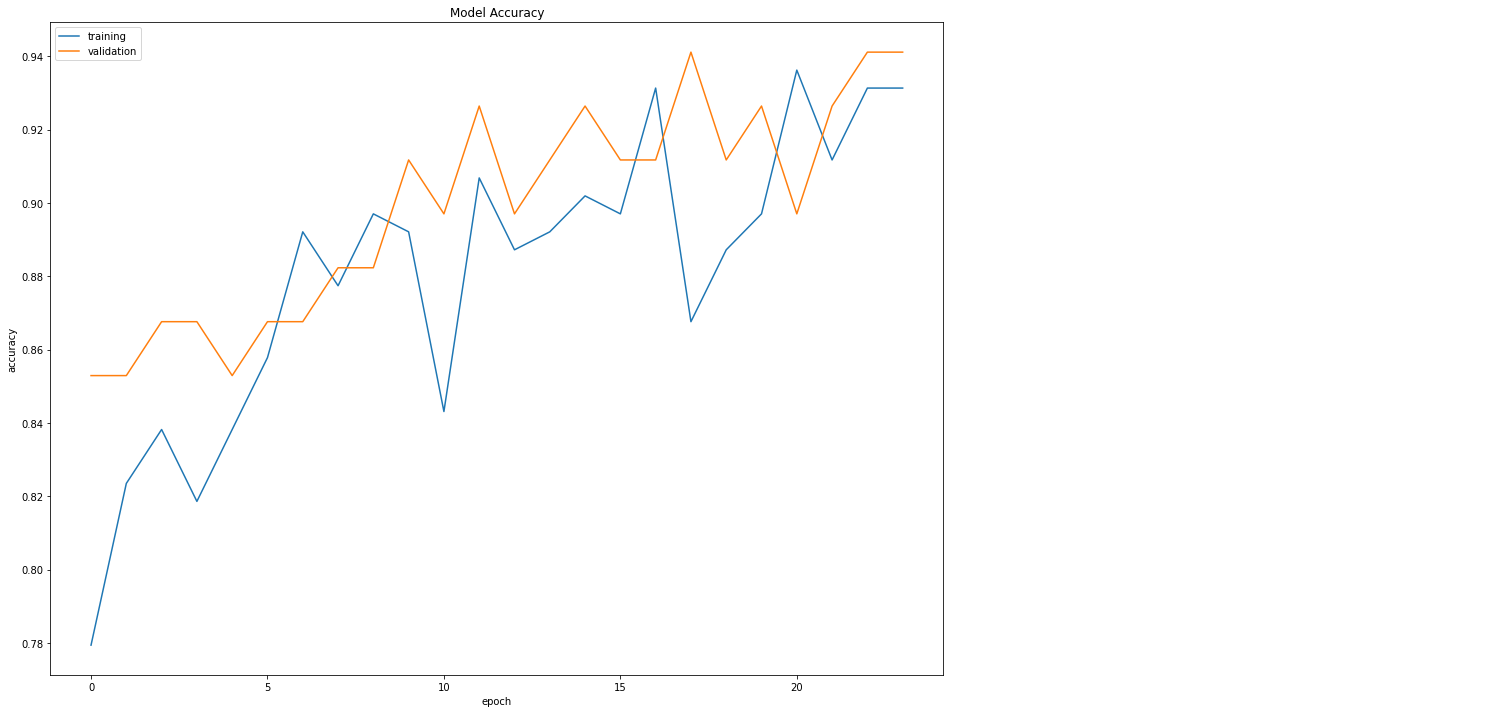

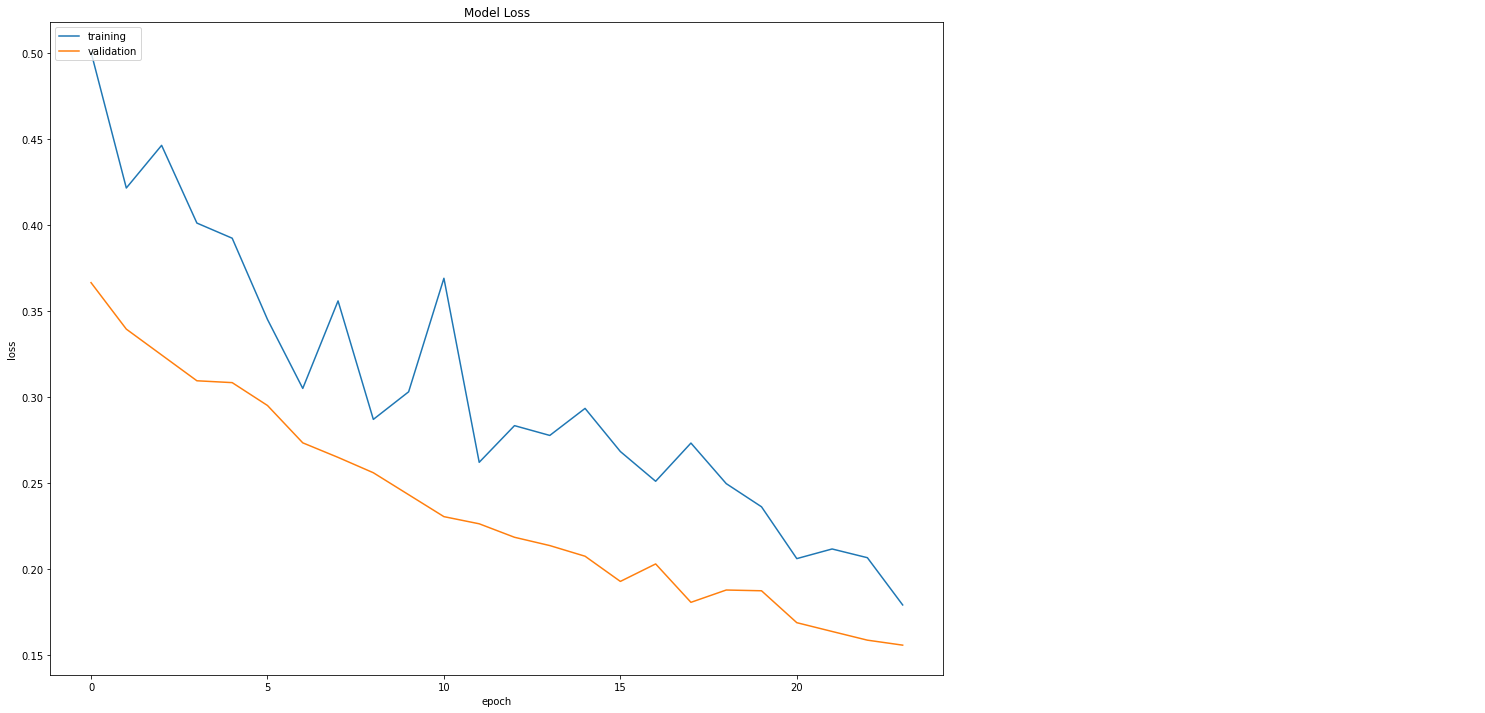

In [41]:
visualize_training(history, n_epochs)

## **Load the saved model**

In [42]:
loaded_model = load_model('../models/inception-model.h5')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Evaluate the model**

In [44]:
_, evaluate_datagen, test_datagen = get_images(299, preprocessing= inception_v3.preprocess_input)

Found 220 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [45]:
model_result = loaded_model.evaluate(
    evaluate_datagen,
    steps= None)

5/5 [==============================] - 1s 45ms/step - loss: 0.1808 - accuracy: 0.9412


In [46]:
test_report = loaded_model.evaluate(
    test_datagen,
    steps= None
)

4/4 [==============================] - 1s 153ms/step - loss: 0.1815 - accuracy: 0.9464


## **Classification Report**

In [47]:
print_classification_report(loaded_model, evaluate_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.93      0.93      0.93        29

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68

Confusion Matrix:
  [[37  2]
 [ 2 27]]


In [48]:
print_classification_report(loaded_model, test_datagen, validation_batch_size)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.96      0.92      0.94        24

    accuracy                           0.95        56
   macro avg       0.95      0.94      0.95        56
weighted avg       0.95      0.95      0.95        56

Confusion Matrix:
  [[31  1]
 [ 2 22]]
